# Introduction to mesonic 

The following examples show how to use mesonic.


- It will demonstrate how to use the different concepts of mesonic.
- The examples are created as a Jupyter notebook, which should be executed from top to bottom.
- However we encourage you to stop and tinker with the example provided.


At first we need to import the package

In [1]:
import mesonic

## Context

The Context is the central interface of a sonification.

In [2]:
context = mesonic.create_context()

<IPython.core.display.Javascript object>

Starting sclang process... Done.
Registering OSC /return callback in sclang... Done.
Loading default sc3nb SynthDefs... Done.
Booting SuperCollider Server... Done.


The Context automatically starts the backend and enables the user to access the different Managers.

In [3]:
context.managers

{'synths': SynthManager({}),
 'buffers': BufferManager([]),
 'records': RecordManager(num of records=0)}

Each Manager now allows to create the respective objects for our sonification. This will be demonstrated down below.

The Context also holds the Timeline and Backend instance

In [4]:
context.timeline

Timeline(is_empty=True)

In [5]:
context.backend.sc

<SC <SCServer addr=('127.0.0.1', 57110), process=<Process 'scsynth' (running) pid=4560>>,
    <SCLang process=<Process 'sclang' (running) pid=26820>>>

The Context allows stopping the backend and all Playbacks with

In [6]:
context.stop()

And also resetting the Timeline and the possible Playback of the Context via

In [7]:
context.reset()

Besides providing these Managers the Context is also responsible for providing the time to the Sonification.

This following sections will demonstrate the usage of the Context and the single concepts.

## Synths

Lets start with creating some Synths with the SynthManager

In [8]:
context.synths

SynthManager({})

* We create the discrete Synth of sc3nb with the name s1 as mutable aswell as immutalbe Synth.

In [9]:
s1m = context.synths.create("s1")
s1i = context.synths.create("s1", mutable=False)

* An we also create the continuous s2 Synth of sc3nb.

In [10]:
s2 = context.synths.create("s2", track=1)

We can now see what Synths are created and how many of them.

In [11]:
context.synths

SynthManager({'s1': 2, 's2': 1})

Each synth lets you also know what Parameters it offers and what their value is.

In [12]:
s2

Synth(s2, {'freq': 400.0, 'amp': 0.3, 'num': 4.0, 'pan': 0.0, 'lg': 0.1, 'gate': 1.0})

The Parameter can also store further data.

In [13]:
s2.freq

Parameter(freq=400.00, default=400.00, bounds=(None, None))

However to actually use them we need to provide them a time using the Context or it will result in failure.

In [14]:
try:    
    s1m.start()
except RuntimeError as error:
    print(error)

No time specified


## Scheduling

The Context offers two ways of providing the time.


* It can be directly set by the user using the `time` property or the `at` context manager.
* Or the realtime mode can be activated.
    * This starts an Playback and uses the time of this Playback as Context time.
    * And also allows the user to use the `now` context manager which allows to spawn the Events together and add an additional delay. 

In [15]:
context.reset() 
# it is a good practice to reset the Context when using it in cells
# to avoid the Timeline getting accidently cluttered by repeated executions

# Example with continuous Synth s2
# creating a raising sound
# using the context.at context manager

# start the s2 Synth at 0.3
with context.at(0.3):
    s2.start(freq=300)

# then raise the frequency
for t in range(4,10):
    with context.at(t/10):  
        s2.freq = 100 * t

# stop the s2 Synth or it will keep playing.
with context.at((t+1)/10): 
    s2.stop()

# Example with mutable discrete Synth s2 
# spawn one sound and change panning

# set the time using the context.time property
context.time = 1.25
# start the Synth
s1m.start(dur=1, pan=1)  # parameters can be provided by keyword
    
# set the panning of the mutable Synth
for i in range(1,4):
    context.time= 1.25 + 0.25 * i
    s1m.pan *= -1  # it is also possible to use /= , += , -=    

# setting the time to None will make it undefined again
# using the context.at context manager is preferred as
# the time is only set inside the with statemate and
# chaged back to None automatically
context.time = None 

# Example with immutable discrete Synth s1
# spawning multiple overlapping sounds
# is only possible with an immutable Synth 
for i in range(5):
    with context.at(3+i/4):
        s1i.start(dur=1.1, freq=100 * i)

The resulting Events will be stored in the timeline of the the Context

In [16]:
context.timeline

Timeline(0.3-5.0 (4.7) #entries=17)

We can also plot the Timeline. 


- each start-end duration of a Synth is depicted as an arrow.
- a point marks a the change of a Parameter of the Synth

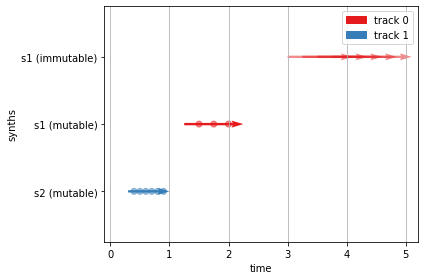

In [17]:
context.timeline.plot()

We can save the content of the current timeline as dict

In [18]:
saved_timeline = context.timeline.to_dict()

And insert the resulting dict with a timeshift.

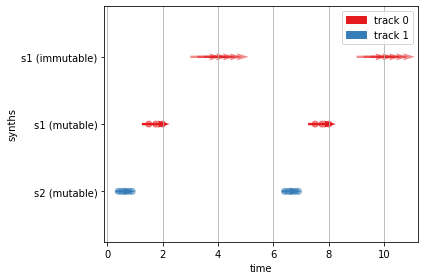

In [19]:
context.timeline.extend(saved_timeline, timeshift=6)
context.timeline.plot()

Let's listen to the Timeline via the realtime mode of the Context


* This will create and start a Playback
* and it will also use the time of the Playback as time of the Context.

In [20]:
pb = context.enable_realtime()

In [21]:
pb.time, context.time

(4.898149013519287, 4.898149013519287)

The realtime Playback of the Context is now saved in `pb` and can be used to start the rendering again.

More details about the Playback can be found below.

Notice that we can use the Synths now directly as we have enabled the realtime mode and the time is provided by the Playback 

In [22]:
# the context manager now yields the current time
# of the realtime Playback from the Context
with context.now() as timepoint:
    s1m.start(dur=0.2, freq=440, pan=0)
    print(f"Started s1m at {timepoint}")

Started s1m at 13.34156322479248


And the start Event of the `s1m` Synth also appears in the Timeline at the `timepoint`. 

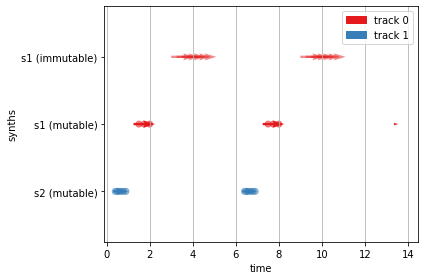

In [23]:
context.timeline.plot()

## Playback

We also got a Playback and stored it in `pb`

In [24]:
pb

Playback(time=16.902233362197876, rate=1)

The Playback offers interactive control. 

* We can jump back to hear listen again

In [25]:
pb.time = 5

* Note: If you jump towards a timepoint were a mutable Synth is used but not started, it will send the set Events to the Backend and leave it up to the backend to provide warnings about the failure.

In [26]:
pb.time = 0.8

Error at SCServer('127.0.0.1', 57110) pid=4560 from scsynth: ('/fail', '/n_set', 'Node 20003 not found')
Error at SCServer('127.0.0.1', 57110) pid=4560 from scsynth: ('/fail', '/n_set', 'Node 20003 not found')
Error at SCServer('127.0.0.1', 57110) pid=4560 from scsynth: ('/fail', '/n_free', 'Node 20003 not found')


* Or we can loop over a part over and over again

In [27]:
pb.loop = True

pb.start_time = 3
pb.end_time = 5

pb.time = 3

* The rate of the Playback can be controlled as well.
* Notice that this only affects the speed of the Playback and not the resulting sound events.

In [28]:
pb.rate = 2

* You can also reverse the Playback. Which is actually a change of the rate into the negative.

In [29]:
pb.reverse()
pb.rate

-2.0

While the Playback runs you can actually modify the Timeline as it will play the changed Events accordingly.
This is also how the realtime Playback works.

In [30]:
with context.at(4):
    s1i.start(freq=440, dur=1)

Let's stop the Playback and disable the realtime mode for now

In [31]:
context.stop()
context.disable_realtime()
context.reset()

## Buffer

mesonic allows the user to load data into Buffers and then play it back with a Synth.

A Buffer is simply storing data in the Backend. This makes it available for fast access using Synths from the backend.

This can be used for Audification as it is demonstrated in the Audification notebook, but also can be used to Play samples.

Let's create a Buffer from a file.

In [32]:
buf = context.buffers.from_file("files/ring.wav")

In [33]:
buf

Buffer(2 x 88320 @ 44100Hz = 1.001s)

Using this Buffer we can create a Synth that will playback this Buffer.

In [34]:
buf_synth = context.synths.from_buffer(buf)

And lets use the realtime mode so we can simply start the Synth

In [35]:
context.enable_realtime()

Playback(time=0.00033974647521972656, rate=1)

In [36]:
buf_synth.start()

Notice that the resulting Synth is a mutable Synth.

In [37]:
buf_synth.mutable

True

This means it cannot be started when it's already running. Notice the following error from SuperCollider

In [38]:
buf_synth.start()
with context.now(delay=0.4):
    buf_synth.start()

Error at SCServer('127.0.0.1', 57110) pid=4560 from scsynth: ('/fail', '/s_new', 'duplicate node ID')


If you want to be able to start the Synth with overlap you need to use an immutable Synth

In [39]:
i_buf_synth = context.synths.from_buffer(buf, mutable=False)

In [40]:
i_buf_synth.start()
with context.now(delay=0.4):
    i_buf_synth.start()

Also make sure that the Synth will stop itself when using a immutable Synth

In [41]:
# loop=1 lets the Synth loop over the Buffer
# and is a Paramter of the Synth used to playback the buffer
i_buf_synth.start(loop=1)

or you will end up with a neverending Synth as immutable Synth cannot be stopped

In [42]:
try:
    i_buf_synth.stop()
except RuntimeError as error:
    print(error)

Immutable Synth can only produce SynthEventType.START but got SynthEventType.STOP


However it can be killed using `context.stop()` which will also stop all playbacks including the realtime Playback of the Context.

In [43]:
context.stop()

In [44]:
context.playback

Playback(running=False)

## Creating audio files

mesonic offers two ways to create audio files.

* realtime recording with `Record`

* non-realtime rendering with the `Context.render` method.

### Record

mesonic allows to use the Record object for recording the output of the Playback.

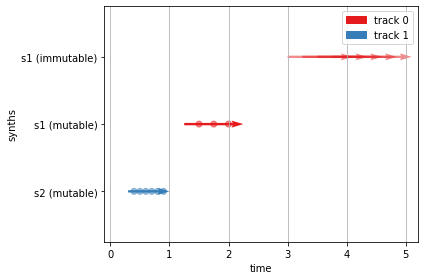

In [45]:
# let's simply use the Events from above again.
context.reset()
context.timeline.extend(saved_timeline)
context.timeline.plot()

The Record can be created using the respective Manager.

In [46]:
context.records

RecordManager(num of records=0)

In [47]:
# create a Record that will write to the provided path
record = context.records.create("./files/record.wav")

# Lets record the two events at the beginning.

# start the record at the 0s
with context.at(0):  
    record.start()

# and end the record at 2.5s
with context.at(2.5):
    record.stop()

The Record now has its Events inserted in the Timeline.

To create the audio file we need to start the Playback so the Events are executed.

In [48]:
# let's create a Playback with a faster rate
pb = context.create_playback(rate=2)
pb.start()
# this should result in a Record where the audio time is shorter. 

In [49]:
record

Record(path=./files/record.wav, finished=True)

Also notice that Records are one time object and can only be used once.

Lets use pya to look at the created Record.

In [50]:
import pya
pya.startup()

AServer: sr: 44100, blocksize: 512,
         Stream Active: True, Device: Speakers (Realtek(R) Audio), Index: 3

Asig('./files/record.wav'): 2 x 55168 @ 44100Hz = 1.251s cn=['0', '1']


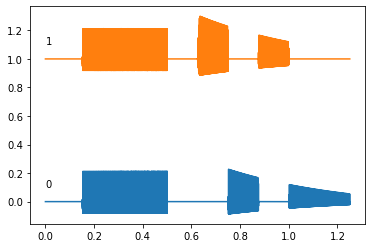

In [51]:
# if the Record is finished you can use the created file.
if record.finished:
    # or you can directly convert it into a pya Asig.
    asig = record.to_asig()
    print(asig)
    # notice that the duration is as expected shorter
    asig.plot(offset=1)
    asig.play()
else:
    print("not finished yet")

### Non-realtime Rendering

If you want a non-realtime rendering of the Timeline you can simply use the render function of the Context

In [52]:
# When using sc3nb as backend we currently need to declare the used Synth explicitly.
import sc3nb as scn

# The SynthDefs here declare what the s1 and s2 Synth do using SuperCollider code.
# For more details refer to the sc3nb and SuperCollider documentation
scn.SynthDef("s1", 
"""{
| freq=400, dur=0.4, att=0.01, amp=0.3, num=4, pan=0 |
    Out.ar(0, Pan2.ar(
        Blip.ar(freq,  num) * EnvGen.kr(Env.perc(att, dur, 1, -2), doneAction: Done.freeSelf),
        pan,
        amp)
    )
}""").add();
scn.SynthDef("s2", 
"""{
| freq=400, amp=0.3, num=4, pan=0, lg=0.1, gate=1 |
    Out.ar(0, Pan2.ar(
        Blip.ar(freq.lag(lg),  num) * EnvGen.kr(Env.asr(0.0, 1.0, 1.0), gate, doneAction: Done.freeSelf),
        pan.lag(lg),
        amp.lag(lg))
    )
}""").add();

We will use our saved Timeline again

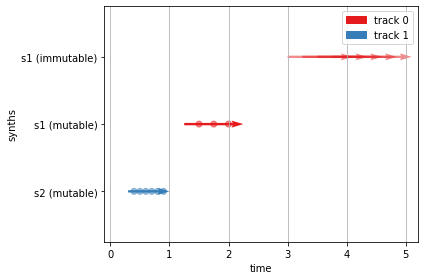

In [53]:
context.reset()
context.timeline.extend(saved_timeline)
context.timeline.plot()

For rendering the Timeline simply use `context.render`

In [54]:
render_filepath = "./files/nrt-render.wav"
context.render(render_filepath)

start time 0
nextOSCPacket 0.3
nextOSCPacket 0.4
nextOSCPacket 0.5
nextOSCPacket 0.6
nextOSCPacket 0.7
nextOSCPacket 0.8
nextOSCPacket 0.9
nextOSCPacket 1
nextOSCPacket 1.25
nextOSCPacket 1.5
nextOSCPacket 1.75
nextOSCPacket 2
nextOSCPacket 3
nextOSCPacket 3.25
nextOSCPacket 3.5
nextOSCPacket 3.75
nextOSCPacket 4
nextOSCPacket 5




Let's listen to the asig.

In [55]:
pya.Asig(render_filepath).play()

Asig('./files/nrt-render.wav'): 8 x 220544 @ 44100Hz = 5.001s cn=['0', '1', '2', '3', '4', '5', '6', '7']

In [56]:
# close the context.
context.close()
# if all contexts are closed the backend should also exit.

Quitting SCServer... Done.
Exiting sclang... Done.
